##**Visión Dinámica - Práctica Seguimiento con Filtro Partículas**

##**Celia García Fernández**

#Data


*   Se preparan los datos para ser ejecutados



In [ ]:
!unzip zip.zip

Archive:  zip.zip
   creating: zip/
  inflating: zip/bg.jpg              
   creating: zip/SecuenciaPelota/
  inflating: zip/SecuenciaPelota/07.jpg  
  inflating: zip/SecuenciaPelota/08.jpg  
  inflating: zip/SecuenciaPelota/09.jpg  
  inflating: zip/SecuenciaPelota/10.jpg  
  inflating: zip/SecuenciaPelota/11.jpg  
  inflating: zip/SecuenciaPelota/12.jpg  
  inflating: zip/SecuenciaPelota/13.jpg  
  inflating: zip/SecuenciaPelota/14.jpg  
  inflating: zip/SecuenciaPelota/15.jpg  
  inflating: zip/SecuenciaPelota/16.jpg  
  inflating: zip/SecuenciaPelota/17.jpg  
  inflating: zip/SecuenciaPelota/18.jpg  
  inflating: zip/SecuenciaPelota/19.jpg  
  inflating: zip/SecuenciaPelota/20.jpg  
  inflating: zip/SecuenciaPelota/21.jpg  
  inflating: zip/SecuenciaPelota/22.jpg  
  inflating: zip/SecuenciaPelota/23.jpg  
  inflating: zip/SecuenciaPelota/24.jpg  
  inflating: zip/SecuenciaPelota/25.jpg  
  inflating: zip/SecuenciaPelota/26.jpg  
  inflating: zip/SecuenciaPelota/27.jpg  
  inflatin

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from scipy import ndimage
import random
from PIL import Image

In [ ]:
# Inicializar parámetros
num_particles = 40
win_size = 20
th=50
path_input = './zip/SecuenciaPelota/'
path_output = './zip/output/'
bg = cv2.cvtColor(cv2.imread('./zip/bg.jpg'), cv2.COLOR_BGR2GRAY).astype(int)
img_weight = 320
img_height = 240


In [ ]:
# Obtengo una lista con los nombres de la secuencia de frames
images_names = os.listdir(path_input)
images_names = sorted(images_names)
for name in images_names:
  if name[-4:] != '.jpg':
    images_names.remove(name)
print(images_names)


['08.jpg', '09.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', '24.jpg', '25.jpg', '26.jpg', '27.jpg', '28.jpg', '29.jpg', '30.jpg', '31.jpg', '32.jpg', '33.jpg', '34.jpg', '35.jpg', '36.jpg', '37.jpg', '38.jpg', '39.jpg', '40.jpg', '41.jpg', '42.jpg', '43.jpg', '44.jpg', '45.jpg', '46.jpg', '47.jpg', '48.jpg', '49.jpg', '50.jpg', '51.jpg', '52.jpg', '53.jpg', '54.jpg', '55.jpg', '56.jpg', '57.jpg', '58.jpg', '59.jpg', '60.jpg']


# Algoritmo Filtro Partículas

In [ ]:
# Función para pintar las partículas
def draw_dot_particles(img, list_particles):
  for point in list_particles:
    cv2.circle(img, center=(point[0][0],point[0][1]), radius=1, color=(255, 0, 0), thickness=4)
  return img

# Función para pintar las ventanas que rodean las partículas
def draw_rectangle_particles(img, list_particles):
  for point in list_particles:
    cv2.rectangle(img, (point[0][0]-win_size ,point[0][1]-win_size), (point[0][0]+win_size ,point[0][1]+win_size), color=(255, 0, 0), thickness=1)
  return img

# Función para pintar únicamente la ventana de la partícula estimada
def draw_rectangle_estimated(img, particle):
  cv2.rectangle(img, (particle[0][0]-win_size ,particle[0][1]-win_size), (particle[0][0]+win_size ,particle[0][1]+win_size), color=(255, 0, 0), thickness=1)
  return img

# Función para realizar la sustracción de fondo
def sustraccion_fondo(img, bg, th):
  mask= np.abs(img-bg) > th
  #Aplico erosión
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
  mask = cv2.erode(mask.astype(np.uint8), kernel)
  return mask

In [ ]:
t=1
#INICIALIZO
xt=[]
for i in range(num_particles):
  xt.append([[(random.randint(0, img_weight)),(random.randint(0, img_height))],0])

for image_name in images_names:
  # CALCULO LOS PESOS
  frame = cv2.cvtColor(cv2.imread(path_input + str(image_name)), cv2.COLOR_BGR2GRAY).astype(int)
  mask = sustraccion_fondo(frame, bg, th)
  sum=0
  for i in xt:
    y=i[0][1]
    x=i[0][0]
    i[1] = np.sum(mask[y-win_size:y+win_size, x-win_size:x+win_size])
    sum = sum + i[1]
  # NORMALIZO LOS PESOS Y CALCULO EL MAX 
  w_max=0
  ws=[]
  for i in xt:
    i[1] = i[1]/sum
    ws.append(i[1])
    if i[1]>w_max:
      w_max = i[1]
      particle_max=i
  # METODO RULETA PARA NUEVA POBLACIÓN
  ws_acumulated = np.add.accumulate(ws)
  xtnew = []
  for i in range(len(ws_acumulated)):
    aleatorio = random.random()
    for y in range(len(ws_acumulated)):
      if ws_acumulated[y]>aleatorio:
        xtnew.append(xt[y])
        xtnew[i][1]=0 #le pongo los pesos a 0
        break
  # DIFUSIÓN PARA NUEVA POBLACIÓN
  xtdiff = []
  for i in xtnew:
    newpos = [(i[0][0] + int(random.gauss(0, 15))), (i[0][1] + int(random.gauss(0, 15)))]
    xtdiff.append([newpos,0])

  frame_to_draw= cv2.imread(path_input + str(image_name))
  img_draw = draw_dot_particles(frame_to_draw, xt)
  img_draw = draw_rectangle_estimated(img_draw, particle_max)
  #plt.imshow(img_draw)

  im = Image.fromarray(img_draw)
  im.save(path_output+str(image_name))

  xt = xtdiff
  t +=1

# *Pruebas

*   Esta sección no es para ejecutar
*   Se trata del desarrollo previo que he realizado paso a paso, con una única imagen de prueba.
* Aquí se muestran las imágenes que he utilizado en la memoria.



[[[180, 148], 0], [[121, 191], 0], [[86, 85], 0], [[114, 28], 0], [[129, 133], 0], [[237, 171], 0], [[243, 123], 0], [[145, 23], 0], [[41, 32], 0], [[305, 218], 0], [[88, 190], 0], [[96, 197], 0], [[8, 151], 0], [[153, 103], 0], [[222, 76], 0], [[98, 41], 0], [[290, 41], 0], [[267, 159], 0], [[56, 21], 0], [[167, 76], 0]]


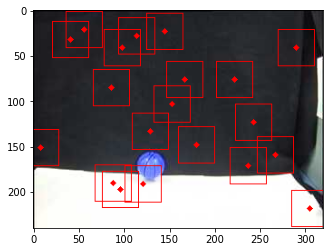

In [ ]:
frame1= cv2.imread('50.jpg')
#INICIALIZO número de partículas iniciales
xt=[]
for i in range(num_particles):
  xt.append([[(random.randint(0, 320)),(random.randint(0, 240))],0])

img_draw = draw_dot_particles(frame1, xt)
img_draw = draw_rectangle_particles(frame1, xt)
plt.imshow(img_draw)
print(xt)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


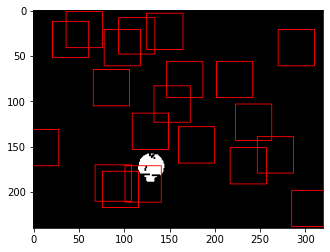

In [ ]:
#EVALUACIÓN DE PESOS. voy a calcular el peso de cada particula
#hago una sustraccion de fondo, elijo la imagen fondo
bg = cv2.cvtColor(cv2.imread('01.jpg'), cv2.COLOR_BGR2GRAY).astype(int)
frame = cv2.cvtColor(cv2.imread('50.jpg'), cv2.COLOR_BGR2GRAY).astype(int)
mask = sustraccion_fondo(frame, bg, th)
#pinto las particulas en la mascara
mask_bgr = cv2.cvtColor(np.float32(mask), cv2.COLOR_GRAY2BGR)
result = draw_rectangle_particles(mask_bgr, xt)
plt.imshow(result, cmap='gray')


[[180, 148], 0]
[[121, 191], 288]
[[86, 85], 0]
[[114, 28], 0]
[[129, 133], 0]
[[237, 171], 0]
[[243, 123], 0]
[[145, 23], 0]
[[41, 32], 0]
[[305, 218], 0]
[[88, 190], 0]
[[96, 197], 0]
[[8, 151], 0]
[[153, 103], 0]
[[222, 76], 0]
[[98, 41], 0]
[[290, 41], 0]
[[267, 159], 0]
[[56, 21], 0]
[[167, 76], 0]


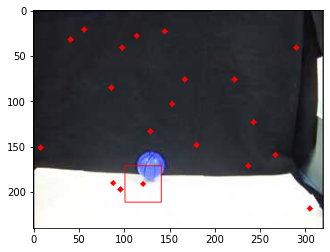

In [ ]:
sum=0
for i in xt:
  y=i[0][1]
  x=i[0][0]
  i[1] = np.sum(mask[y-win_size:y+win_size, x-win_size:x+win_size])
  sum = sum + i[1]
  print(i)

#normalizo los pesos y calculo el max
w_max=0
ws=[]
for i in xt:
  i[1] = i[1]/sum
  ws.append(i[1])
  if i[1]>w_max:
    w_max = i[1]
    particle_max=i
  #print(i)

#ESTIAMCIÓN: estimo la posicion en cada instante t, eligiendo la que tenga el peso maximo.
#Calculo la particula estimada, la que mas pixeles blancos tenga en la region.
#calculo el estimado, el maximo.
frame1= cv2.imread('50.jpg')
img_draw = draw_dot_particles(frame1, xt)
estimated = draw_rectangle_estimated(img_draw, particle_max)
plt.imshow(estimated)

[[[123, 182], 0], [[123, 182], 0], [[123, 182], 0], [[114, 150], 0], [[123, 182], 0], [[123, 182], 0], [[123, 182], 0], [[145, 180], 0], [[123, 182], 0], [[123, 182], 0], [[114, 150], 0], [[114, 150], 0], [[114, 150], 0], [[145, 180], 0], [[145, 180], 0], [[123, 182], 0], [[145, 180], 0], [[123, 182], 0], [[145, 180], 0], [[145, 180], 0]]


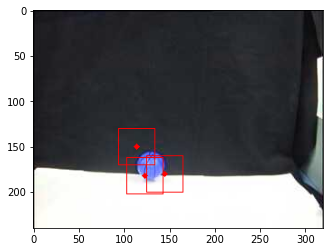

In [ ]:
#SELECCION. MÉTODO DE A RULETA. Creo el siguiente conjunto de particulas para el siguiente t.
#Resampling.
ws_acumulated = np.add.accumulate(ws)
#nueva poblacion:
xtnew = []
for i in range(len(ws_acumulated)):
  aleatorio = random.random()
  for y in range(len(ws_acumulated)):
    if ws_acumulated[y]>aleatorio:
      xtnew.append(xt[y])
      xtnew[i][1]=0 #le pongo los pesos a 0
      break
print(xtnew)
frame1= cv2.imread('50.jpg')
img_draw = draw_dot_particles(frame1, xtnew)
img_draw = draw_rectangle_particles(frame1, xtnew)
plt.imshow(img_draw)

[[[123, 182], 0], [[123, 182], 0], [[123, 182], 0], [[114, 150], 0], [[123, 182], 0], [[123, 182], 0], [[123, 182], 0], [[145, 180], 0], [[123, 182], 0], [[123, 182], 0], [[114, 150], 0], [[114, 150], 0], [[114, 150], 0], [[145, 180], 0], [[145, 180], 0], [[123, 182], 0], [[145, 180], 0], [[123, 182], 0], [[145, 180], 0], [[145, 180], 0]]
[[[122, 181], 0], [[127, 182], 0], [[119, 183], 0], [[115, 151], 0], [[123, 180], 0], [[124, 184], 0], [[122, 182], 0], [[152, 175], 0], [[121, 185], 0], [[127, 181], 0], [[118, 146], 0], [[115, 150], 0], [[125, 155], 0], [[147, 177], 0], [[143, 180], 0], [[130, 181], 0], [[144, 178], 0], [[122, 182], 0], [[148, 189], 0], [[145, 169], 0]]


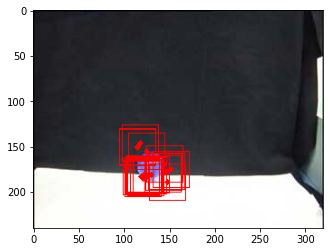

In [ ]:
#DIFUSION. Perturbo los datos, porque se ha producido un empobrecimiento de la muetra
print(xtnew)
xtdiff = []
for i in xtnew:
  newpos = [(i[0][0] + int(random.gauss(0, 5))), (i[0][1] + int(random.gauss(0, 5)))]
  xtdiff.append([newpos,0])
  #new = xtnew[i][0][0] + int(random.gauss(0, 5))
  #xtnew[i][0][0] = new
print(xtdiff)
frame1= cv2.imread('50.jpg')
img_draw = draw_dot_particles(frame1, xtdiff)
img_draw = draw_rectangle_particles(frame1, xtdiff)
plt.imshow(img_draw)